In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


In [3]:
training_data = datasets.FashionMNIST(
    root = "data",
    train=True,
    download=False,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
)

In [4]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

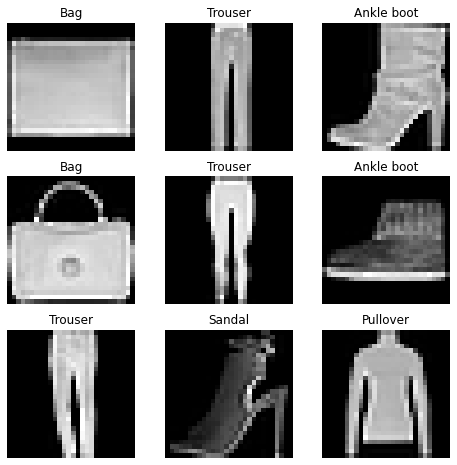

In [5]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [6]:
batch_size = 64

# Create dataloaders
train_loader = DataLoader(training_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("shape of y", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
shape of y torch.Size([64]) torch.int64


In [7]:
# the neural network

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = Net().to(device)
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [8]:
# Optimizing the model parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        
        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 6
for t in range(epochs):
    print(f"Epochs {t+1}.....................")
    train(dataloader=train_loader, model=model, loss_fn=loss_fn, optimizer=optimizer)
    test(test_loader, model)
print("Done")

Epochs 1.....................
loss: 2.305020 [    0/60000]
loss: 2.293751 [ 6400/60000]
loss: 2.283400 [12800/60000]
loss: 2.292862 [19200/60000]
loss: 2.263267 [25600/60000]
loss: 2.263277 [32000/60000]
loss: 2.267815 [38400/60000]
loss: 2.243920 [44800/60000]
loss: 2.251131 [51200/60000]
loss: 2.259042 [57600/60000]
Test error: 
 Accuracy: 31.6%, Avg loss: 0.035111 

Epochs 2.....................
loss: 2.238610 [    0/60000]
loss: 2.212684 [ 6400/60000]
loss: 2.195516 [12800/60000]
loss: 2.225475 [19200/60000]
loss: 2.146758 [25600/60000]
loss: 2.170826 [32000/60000]
loss: 2.181951 [38400/60000]
loss: 2.133544 [44800/60000]
loss: 2.153962 [51200/60000]
loss: 2.158899 [57600/60000]
Test error: 
 Accuracy: 44.8%, Avg loss: 0.033122 

Epochs 3.....................
loss: 2.138730 [    0/60000]
loss: 2.078390 [ 6400/60000]
loss: 2.032804 [12800/60000]
loss: 2.086885 [19200/60000]
loss: 1.946255 [25600/60000]
loss: 1.989822 [32000/60000]
loss: 2.054332 [38400/60000]
loss: 1.962657 [44800/6

In [12]:
# Saving model
torch.save(model.state_dict(), "models/model.torch")
print("Saved model state")

Saved model state


In [13]:
# Loading model
model = Net()
model.load_state_dict(torch.load("models/model.torch"))

<All keys matched successfully>

In [14]:
# Making predictions
model.eval()
x, y = test_data[2]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Trouser", Actual: "Trouser"
